# Importação das bibliotecas e criação de parâmetros

In [1]:
import os
import logging
import sys

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, TensorDataset, ConcatDataset, Dataset
from torch.backends import cudnn

import torchvision
from torchvision import datasets, transforms

from tqdm import tqdm
from collections import Counter
import random
from PIL import Image


In [2]:
device = 'cuda'
num_class = 101
batch_size = 256
num_epochs = 20
step_size =  6

In [3]:
def imgshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

    return

# Download do Dataset e transformações

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionando as imagens para 224x224
    transforms.ToTensor(),
])

# Carregar o dataset Caltech101
caltech101_dataset = datasets.Caltech101(
    root='/content/sample_data',
    download=True,
    transform=transform
)

# Obter rótulos do dataset
labels = [target for _, target in caltech101_dataset]

class_counts = Counter(labels)
print("Contagem de amostras por classe:", class_counts)

threshold = 50
minority_classes = [cls for cls, count in class_counts.items() if count < threshold]

# Criar um novo dataset com aumento de dados para as classes minoritárias
class AugmentedCaltech101(Dataset):
    def __init__(self, dataset, minority_classes):
        self.dataset = dataset
        self.minority_classes = minority_classes
        self.augmented_samples = []
        self.augmented_labels = []
        self.augment_data()

    def __len__(self):
        return len(self.dataset) + len(self.augmented_samples)

    def __getitem__(self, idx):
        if idx < len(self.dataset):
            return self.dataset[idx]  # Retorna amostra original

        return self.augmented_samples[idx - len(self.dataset)], self.augmented_labels[idx - len(self.dataset)]

    def augment_data(self):
        for idx, (image, label) in enumerate(self.dataset):
            if label in self.minority_classes:
                for _ in range(5):  # Criar 5 amostras aumentadas
                    augmented_image = image.clone()
                    augmented_image += torch.randn_like(image) * 0.1  # Adicionando ruído
                    augmented_image = torch.clamp(augmented_image, 0, 1)
                    self.augmented_samples.append(augmented_image)
                    self.augmented_labels.append(label)

        print(f"Foram geradas {len(self.augmented_samples)} novas amostras aumentadas.")

# Criar o dataset aumentado
augmented_dataset = AugmentedCaltech101(caltech101_dataset, minority_classes)

Downloading...
From (original): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
From (redirected): https://drive.usercontent.google.com/download?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&confirm=t&uuid=81318e72-2011-4d22-ac50-19cd4c1cf9dc
To: /content/sample_data/caltech101/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:02<00:00, 48.3MB/s]


Extracting /content/sample_data/caltech101/101_ObjectCategories.tar.gz to /content/sample_data/caltech101


Downloading...
From (original): https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
From (redirected): https://drive.usercontent.google.com/download?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m&confirm=t&uuid=cc5d2720-f052-4246-9345-3290a7f849a5
To: /content/sample_data/caltech101/Annotations.tar
100%|██████████| 14.0M/14.0M [00:00<00:00, 37.2MB/s]


Extracting /content/sample_data/caltech101/Annotations.tar to /content/sample_data/caltech101
Contagem de amostras por classe: Counter({5: 800, 3: 798, 0: 435, 1: 435, 94: 239, 2: 200, 12: 128, 19: 123, 55: 114, 23: 107, 47: 100, 46: 99, 13: 98, 16: 91, 50: 88, 63: 87, 54: 86, 86: 86, 92: 86, 15: 85, 39: 85, 90: 85, 81: 84, 75: 82, 57: 81, 51: 80, 58: 78, 65: 76, 35: 75, 93: 75, 26: 73, 27: 70, 25: 69, 34: 68, 31: 67, 40: 67, 41: 67, 60: 66, 33: 65, 36: 64, 38: 64, 53: 64, 84: 64, 88: 64, 79: 63, 22: 62, 56: 61, 100: 60, 21: 59, 76: 59, 87: 59, 96: 59, 30: 57, 74: 57, 82: 57, 98: 56, 4: 55, 66: 55, 9: 54, 49: 54, 37: 53, 72: 53, 32: 52, 29: 51, 45: 51, 17: 50, 28: 50, 77: 49, 91: 49, 8: 47, 20: 47, 24: 47, 69: 47, 10: 46, 42: 45, 71: 45, 85: 45, 14: 43, 18: 43, 61: 43, 6: 42, 7: 42, 48: 42, 59: 41, 62: 40, 78: 40, 68: 39, 80: 39, 99: 39, 70: 38, 95: 37, 67: 35, 83: 35, 89: 35, 43: 34, 44: 34, 73: 34, 97: 34, 11: 33, 64: 32, 52: 31})
Foram geradas 6860 novas amostras aumentadas.


#Demonstração do dataset

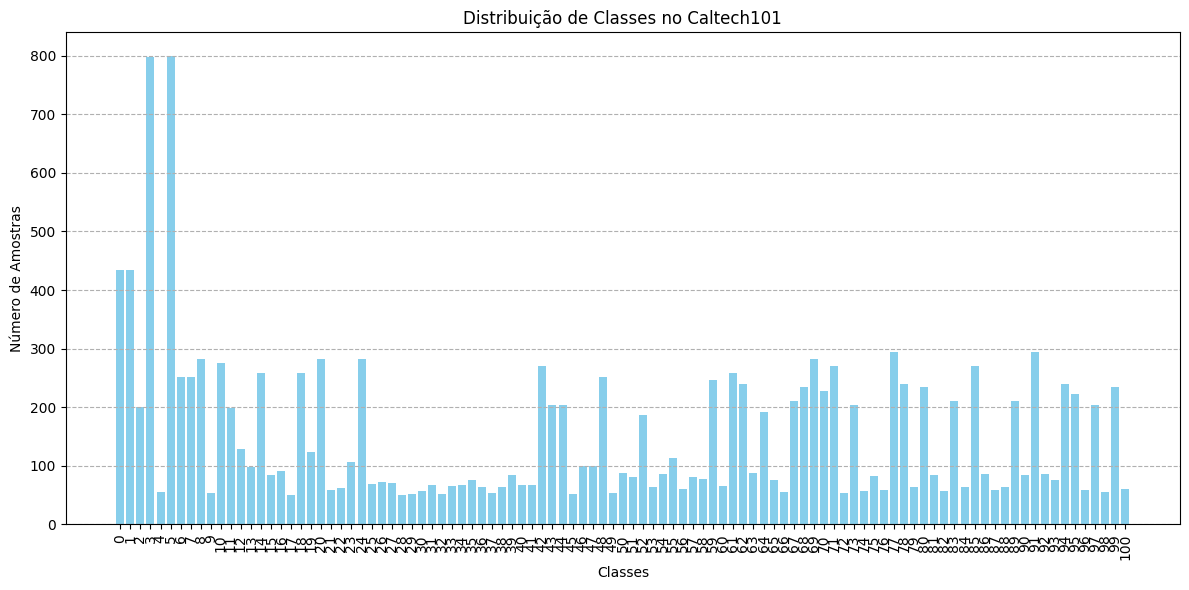

In [5]:
# Acessar os rótulos das classes
class_labels = [label for _, label in augmented_dataset]

# Contar amostras por classe
class_counts = Counter(class_labels)

# Preparar os dados para o gráfico
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Criar o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Número de Amostras')
plt.title('Distribuição de Classes no Caltech101')
plt.xticks(classes)  # Adiciona os rótulos das classes
plt.xticks(rotation=90)  # Rotaciona os rótulos para melhor visualização
plt.grid(axis='y', linestyle='--')
plt.tight_layout()  # Ajusta o layout
plt.show()

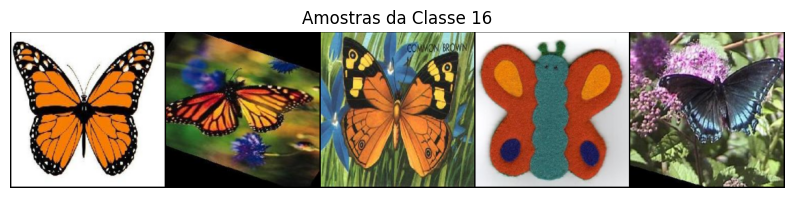

In [6]:
import torchvision.utils as vutils

def plot_images_by_class(dataset, class_idx, num_images=5):
    # Filtrar as imagens da classe selecionada
    images = [img for img, label in dataset if label == class_idx][:num_images]

    # Plotar as imagens
    plt.figure(figsize=(10, 10))
    grid_img = vutils.make_grid(images, nrow=num_images)  # As imagens já são tensores
    plt.imshow(grid_img.permute(1, 2, 0))  # Converte para formato adequado para plt.imshow
    plt.title(f'Amostras da Classe {class_idx}')
    plt.axis('off')
    plt.show()

plot_images_by_class(caltech101_dataset, class_idx=16)


In [7]:
data_dir = '/content/sample_data/caltech101/101_ObjectCategories'

from torch.utils.data import random_split

dataset_size = len(augmented_dataset)  # Tamanho total do dataset

train_size = int(0.8 * dataset_size)  # 80% para treino
val_size = int(0.1 * dataset_size)    # 10% para validação
test_size = dataset_size - train_size - val_size  # O restante para teste (10%)

# Dividindo o dataset completo em treino, validação e teste
train_dataset, val_dataset, test_dataset = random_split(augmented_dataset, [train_size, val_size, test_size])

print(f'Tamanho do treino: {len(train_dataset)}')
print(f'Tamanho da validação: {len(val_dataset)}')
print(f'Tamanho do teste: {len(test_dataset)}')

Tamanho do treino: 12429
Tamanho da validação: 1553
Tamanho do teste: 1555


In [8]:
def custom_collate_fn(batch):
    for i in range(len(batch)):
        if batch[i][0].size(0) == 1:  # Verifica se a imagem tem 1 canal (grayscale)
            batch[i] = (batch[i][0].repeat(3, 1, 1), batch[i][1])
    return torch.utils.data.dataloader.default_collate(batch)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=custom_collate_fn, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn, num_workers=0)

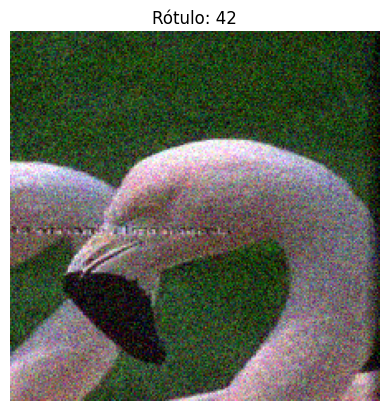

In [9]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# Mostrar a primeira imagem do batch
image = images[0]
label = labels[0].item()

image = image.permute(1, 2, 0).numpy()

plt.imshow(image)
plt.title(f'Rótulo: {label}')
plt.axis('off')
plt.show()

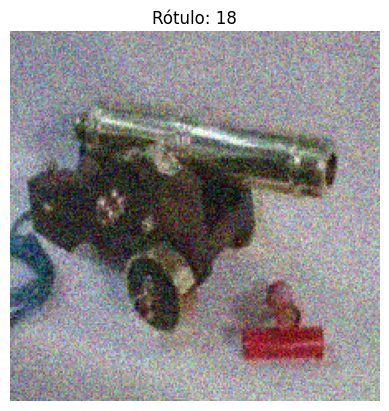

In [10]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# Mostrar a primeira imagem do batch
image = images[0]
label = labels[0].item()

image = image.permute(1, 2, 0).numpy()

plt.imshow(image)
plt.title(f'Rótulo: {label}')
plt.axis('off')
plt.show()

# Criação do modelo

Utiliza 5 camadas convolucionais:
1. 3 canais de entrada, 64 filtros, kernel 11x11, stride 4, padding 2
2. 64 filtros, 192 filtros, kernel 5x5, padding 2
3. 192 filtros, 384 filtros, kernel 3x3, padding 1
4. 384 filtros, 256 filtros, kernel 3x3, padding 1
5. 256 filtros, 256 filtros, kernel 3x3, padding 1

3 camadas de pooling para reduzir a dimensionalidade.

3 camadas lineares (fully connected) com ReLU e dropout entre elas.
A saída final é ajustada para 101 classes.




In [11]:
class Caltech101(nn.Module):
    def __init__(self, num_classes=101):  # 101 classes para o Caltech101
        super(Caltech101, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),  # Saída ajustada para 101 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [12]:
from sklearn.metrics import classification_report

# Função para calcular e imprimir o classification report
def classification_report_per_class(outputs, labels):
    return classification_report(labels.cpu(), outputs.cpu(), zero_division=0)

In [13]:
#Checando o número de classes
all_labels = []
for _, labels in train_dataloader:
    all_labels.extend(labels.numpy())

num_classes = len(set(all_labels))
print(num_class)

101


#Iniciando o loop de treinamento e validação

In [14]:
# Definindo a seed
seed = 42
random.seed(seed)

torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True  # Para garantir que os resultados sejam determinísticos
torch.backends.cudnn.benchmark = False

epoch_loss_train = []
epoch_loss_val = []
epoch_acc_val = []
epoch_acc_train = []

# Instanciar o modelo
model = Caltech101()

# Definir a função de perda e o otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

for epoch in range(20):  # 20 épocas
    model.train()
    running_loss_train = 0.0
    running_corrects_train = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs, labels
        optimizer.zero_grad()  # Zerar gradientes

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        # Estatísticas
        running_loss_train += loss.item() * inputs.size(0)
        running_corrects_train += (torch.max(outputs, 1)[1] == labels).sum().item()

    epoch_loss_train.append(running_loss_train / len(train_dataloader.dataset))
    epoch_acc_train.append(running_corrects_train / len(train_dataloader.dataset))

    model.eval()
    running_loss_val = 0.0
    running_corrects_val = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs, labels
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            all_preds.append(preds)
            all_labels.append(labels)

            # Estatísticas
            running_loss_val += loss.item() * inputs.size(0)
            running_corrects_val += (torch.max(outputs, 1)[1] == labels).sum().item()

    epoch_loss_val.append(running_loss_val / len(val_dataloader.dataset))
    epoch_acc_val.append(running_corrects_val / len(val_dataloader.dataset))
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Imprimir as estatísticas de cada época
    print(f"Época {epoch+1}/20")
    print(f"  Treino - Loss: {epoch_loss_train[-1]:.4f}, Acurácia: {epoch_acc_train[-1]:.4f}")
    print(f"  Validação - Loss: {epoch_loss_val[-1]:.4f}, Acurácia: {epoch_acc_val[-1]:.4f}")

Época 1/20
  Treino - Loss: 4.3500, Acurácia: 0.0443
  Validação - Loss: 4.3053, Acurácia: 0.0522
Época 2/20
  Treino - Loss: 4.1830, Acurácia: 0.0672
  Validação - Loss: 4.1877, Acurácia: 0.0798
Época 3/20
  Treino - Loss: 3.8904, Acurácia: 0.1307
  Validação - Loss: 3.6000, Acurácia: 0.1919
Época 4/20
  Treino - Loss: 3.1880, Acurácia: 0.2613
  Validação - Loss: 2.8215, Acurácia: 0.3451
Época 5/20
  Treino - Loss: 2.6535, Acurácia: 0.3716
  Validação - Loss: 2.4009, Acurácia: 0.4282
Época 6/20
  Treino - Loss: 2.0609, Acurácia: 0.4920
  Validação - Loss: 1.8924, Acurácia: 0.5673
Época 7/20
  Treino - Loss: 1.5854, Acurácia: 0.6012
  Validação - Loss: 1.5005, Acurácia: 0.6613
Época 8/20
  Treino - Loss: 1.1878, Acurácia: 0.6923
  Validação - Loss: 1.2137, Acurácia: 0.7270
Época 9/20
  Treino - Loss: 0.9428, Acurácia: 0.7460
  Validação - Loss: 1.1131, Acurácia: 0.7656
Época 10/20
  Treino - Loss: 0.7548, Acurácia: 0.7890
  Validação - Loss: 0.9585, Acurácia: 0.7997
Época 11/20
  Trein

In [15]:
print(classification_report_per_class(all_preds, all_labels))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89        40
           1       0.95      0.95      0.95        40
           2       1.00      0.80      0.89        25
           3       0.99      0.99      0.99        73
           4       0.83      0.62      0.71         8
           5       0.97      0.94      0.96        82
           6       0.88      1.00      0.94        29
           7       0.94      1.00      0.97        29
           8       0.97      0.97      0.97        29
           9       0.33      0.20      0.25         5
          10       0.71      1.00      0.83        20
          11       1.00      1.00      1.00        20
          12       0.40      0.40      0.40        10
          13       0.50      0.64      0.56        11
          14       0.91      1.00      0.95        20
          15       0.67      0.57      0.62         7
          16       0.67      0.29      0.40         7
          17       1.00    

In [16]:
#Salvando o modelo para usar futuramente
torch.save(model, 'ModeloNNCompleto.pth')

#Resultados do treinamento e validação

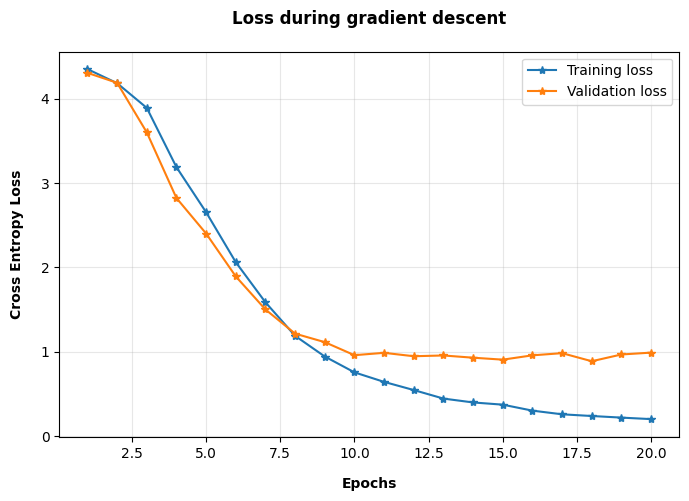

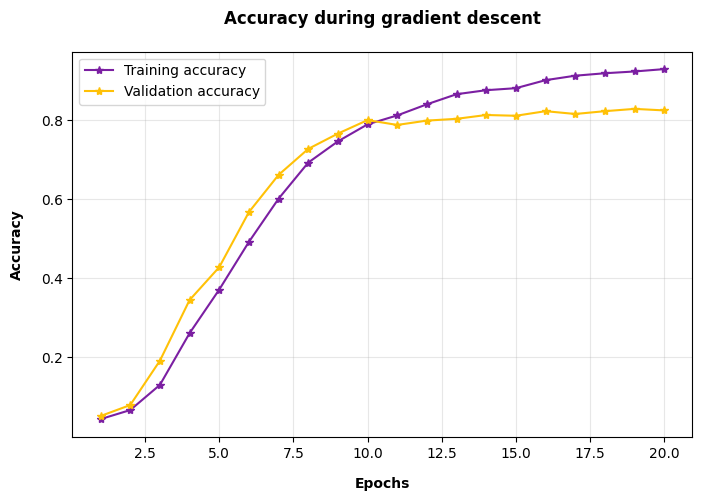

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

epochs = [i for i in range(1, num_epochs+1)]
ax.plot(epochs, epoch_loss_train, linestyle='-', marker='*', label='Training loss')
ax.plot(epochs, epoch_loss_val, linestyle='-', marker='*', label='Validation loss')

ax.set_xlabel('Epochs', labelpad=12, fontweight='bold')
ax.set_ylabel('Cross Entropy Loss', labelpad=12, rotation=90, fontweight='bold')

ax.set_title('Loss during gradient descent', pad=20, fontweight='bold')

ax.legend()
plt.grid(alpha=0.3)
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

epochs = [i for i in range(1, num_epochs+1)]
ax.plot(epochs, epoch_acc_train, color='#7B1FA2', linestyle='-', marker='*', label='Training accuracy')
ax.plot(epochs, epoch_acc_val, color='#FFC107', linestyle='-', marker='*', label='Validation accuracy')

ax.set_xlabel('Epochs', labelpad=12, fontweight='bold')
ax.set_ylabel('Accuracy', labelpad=12, rotation=90, fontweight='bold')

ax.set_title('Accuracy during gradient descent', pad=20, fontweight='bold')

ax.legend()
plt.grid(alpha=0.3)
plt.show()

#Resultados no conjunto de teste

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

def precision(outputs, labels):
    return precision_score(labels.cpu(), outputs.cpu(), average='weighted', zero_division=0)

def recall(outputs, labels):
    return recall_score(labels.cpu(), outputs.cpu(), average='weighted', zero_division=0)

def f1(outputs, labels):
    return f1_score(labels.cpu(), outputs.cpu(), average='weighted', zero_division=0)

In [19]:
def evaluate_on_test(model, test_dataloader, device):
    model.eval()  # Colocar o modelo em modo de avaliação
    test_running_loss = 0.0
    test_running_corrects = 0
    all_preds = []
    all_labels = []

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs, labels

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Predições
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds)
            all_labels.append(labels)

            test_running_loss += loss.item() * inputs.size(0)
            test_running_corrects += (preds == labels).sum().item()

    # Calcular loss e acurácia médios
    test_loss = test_running_loss / len(test_dataloader.dataset)
    test_acc = test_running_corrects / len(test_dataloader.dataset)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    test_precision = precision(all_preds, all_labels)
    test_recall = recall(all_preds, all_labels)
    test_f1 = f1(all_preds, all_labels)

    print(f"Teste - Loss: {test_loss:.4f}, Acurácia: {test_acc:.4f}")
    print(f"Precisão: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-Score: {test_f1:.4f}")

    return test_loss, test_acc, test_precision, test_recall, test_f1

In [20]:
test_loss, test_acc, test_precision, test_recall, test_f1 = evaluate_on_test(model, test_dataloader, device)

Teste - Loss: 0.9859, Acurácia: 0.8257
Precisão: 0.8136, Recall: 0.8257, F1-Score: 0.8103


In [21]:
#Ver quais classes tiveram precisão e recall = 0
def count_zero_precision_recall(y_true, y_pred, num_classes=101):
    precision = []
    recall = []

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    for class_label in range(num_classes):
        precision_value = precision_score(y_true, y_pred, labels=[class_label], average='macro', zero_division=0)
        recall_value = recall_score(y_true, y_pred, labels=[class_label], average='macro', zero_division=0)
        precision.append(precision_value)
        recall.append(recall_value)

    precision = np.array(precision)
    recall = np.array(recall)

    zero_precision_classes = [i for i in range(num_classes) if precision[i] == 0]
    zero_recall_classes = [i for i in range(num_classes) if recall[i] == 0]

    print(f"Número de classes com Precision = 0: {len(zero_precision_classes)}")
    print(f"Classes com Precision = 0: {zero_precision_classes}")

    print(f"Número de classes com Recall = 0: {len(zero_recall_classes)}")
    print(f"Classes com Recall = 0: {zero_recall_classes}")

    zero_classes = set(zero_precision_classes) & set(zero_recall_classes)
    print(f"Número de classes com Precision e Recall = 0: {len(zero_classes)}")
    print(f"Classes com Precision e Recall = 0: {zero_classes}")

count_zero_precision_recall(all_labels.cpu(),all_preds.cpu(), num_classes=101)

Número de classes com Precision = 0: 6
Classes com Precision = 0: [27, 28, 29, 31, 58, 82]
Número de classes com Recall = 0: 6
Classes com Recall = 0: [27, 28, 29, 31, 58, 82]
Número de classes com Precision e Recall = 0: 6
Classes com Precision e Recall = 0: {82, 58, 27, 28, 29, 31}


#Testando o modelo para amostras específicas

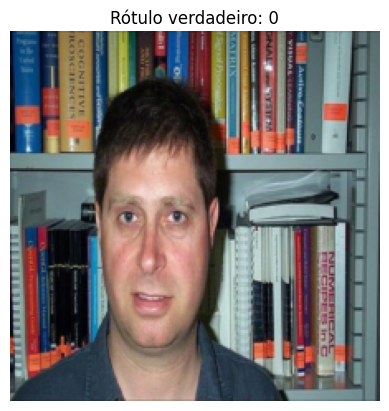

Classe prevista: 42


In [49]:
modelX = Caltech101()
torch.load('/content/ModeloNNCompleto.pth', weights_only=False)
modelX.eval()

def predict_image(model, dataset, index):
    modelX.eval()
    img, label = dataset[index]

    plt.imshow(img.permute(1, 2, 0))
    plt.title(f'Rótulo verdadeiro: {label}')
    plt.axis('off')
    plt.show()

    img = img.unsqueeze(0)

    with torch.no_grad():
        output = modelX(img)
        _, predicted = torch.max(output, 1)

    print(f"Classe prevista: {predicted.item()}")

predict_image(modelX, augmented_dataset, index=1)